In [2]:
import pandas as pd

In [133]:
#load demographics (which we will merge in to each vol table later
df_demog = (pd
            .read_table('resources/subjects_HCA.csv',sep=',')
            .assign(age = lambda df_: df_.interview_age/12.0)
            .assign(subject = lambda df_: 'sub-' + df_.subject.astype(str))            
           )

      
methods = ['freesurfer','ashs',
               'hippunfold-t2-freesurferatlas','hippunfold-t2-magdeburgatlas','hippunfold-t2-bigbrainatlas',
               'hippunfold-t1-freesurferatlas','hippunfold-t1-magdeburgatlas','hippunfold-t1-bigbrainatlas']
methods_abbr = ['FS','ASHS','HippUnfold-T2-FSatlas','HippUnfold-T2-ASHSatlas','HippUnfold-T2-BigBrainatlas',
                       'HippUnfold-T1-FSatlas','HippUnfold-T1-ASHSatlas','HippUnfold-T1-BigBrainatlas']

id_cols = ['subject','hemi','age','sex']

luts = {'freesurfer': 'resources/freesurfer_v21_CA_subfields_dseg.tsv',
        'ashs': 'resources/desc-subfields_atlas-magdeburg_dseg.tsv',
        'hippunfold-t1-freesurferatlas': 'resources/hippunfold_desc-subfields_atlas-freesurfer_dseg.tsv',
        'hippunfold-t1-magdeburgatlas': 'resources/hippunfold_desc-subfields_atlas-magdeburg_dseg.tsv',
        'hippunfold-t1-bigbrainatlas': 'resources/hippunfold_desc-subfields_atlas-bigbrain_dseg.tsv',
        'hippunfold-t2-freesurferatlas': 'resources/hippunfold_desc-subfields_atlas-freesurfer_dseg.tsv',
        'hippunfold-t2-magdeburgatlas': 'resources/hippunfold_desc-subfields_atlas-magdeburg_dseg.tsv',
        'hippunfold-t2-bigbrainatlas': 'resources/hippunfold_desc-subfields_atlas-bigbrain_dseg.tsv'}
               
all_subfields = { method: pd.read_table(luts[method]).abbreviation.to_list() for method in methods }



    
df = pd.concat( [(pd
            .read_table(f'results/{method}_volumes.tsv') #read table
            .merge(df_demog,on='subject')  # merge in demographics
            .melt(id_vars=id_cols,value_vars=all_subfields[method],var_name='subfield',value_name='volume')  #convert from wide to tidy
            .assign(method = lambda df_:abbr)  #add a column for the method
           )
            for method,abbr in zip(methods,methods_abbr) ]   #concatenate all the tidy tables 
         )

    
    
df.sample(20)
    
    

,subject,hemi,age,sex,subfield,volume,method
180,sub-6291976,L,41.916667,M,ParaSub,2.680005,HippUnfold-T1-FSatlas
574,sub-7079074,L,47.000000,M,CA4_DG,213.007117,HippUnfold-T1-ASHSatlas
925,sub-9329687,R,58.500000,M,CA3,171.732936,HippUnfold-T2-FSatlas
529,sub-9436688,R,67.916667,F,CA2,128.979746,HippUnfold-T2-BigBrainatlas
1493,sub-7101546,R,62.833333,M,SRLM,487.419174,HippUnfold-T2-FSatlas
650,sub-8502872,L,81.083333,F,CA1,398.292892,HippUnfold-T2-FSatlas
758,sub-7530670,L,38.500000,M,CA3,385.329364,HippUnfold-T1-BigBrainatlas
348,sub-6117051,L,57.416667,F,PreSub,236.468592,HippUnfold-T2-FSatlas
555,sub-7956199,R,41.416667,F,CA2,92.329943,HippUnfold-T2-BigBrainatlas
1241,sub-9157179,R,40.000000,M,Tail,250.239666,HippUnfold-T2-FSatlas


## Bland-altman plots

In [156]:
def plot_bland_altman(df,methods1,methods2,subfields,figsize=(18,16)):

    f, axs = plt.subplots(ncols=len(methods1),nrows=len(subfields), figsize=figsize)


    for i,(method1,method2) in enumerate(zip(methods1,methods2)):
        for j,subfield in enumerate(subfields):

            m1 = (df
                  .query(f'subfield == "{subfield}" and method == "{method1}"')
                  .volume
                 )
            m2 = (df
                  .query(f'subfield == "{subfield}" and method == "{method2}"')
                  .volume
                 )    
            sm.graphics.mean_diff_plot(m1,m2,ax=axs[j][i])


    #add column and row labels:

    rows = subfields
    cols = [f'{method1} vs {method2}' for method1,method2 in zip(methods1,methods2) ]


    for ax, col in zip(axs[0], cols):
        ax.set_title(col,size='xx-large')

    for ax, row in zip(axs[:,0], rows):
        ax.set_ylabel(row, rotation=90, size='xx-large')

    for ax in axs[:,1]:
        ax.set_ylabel('')


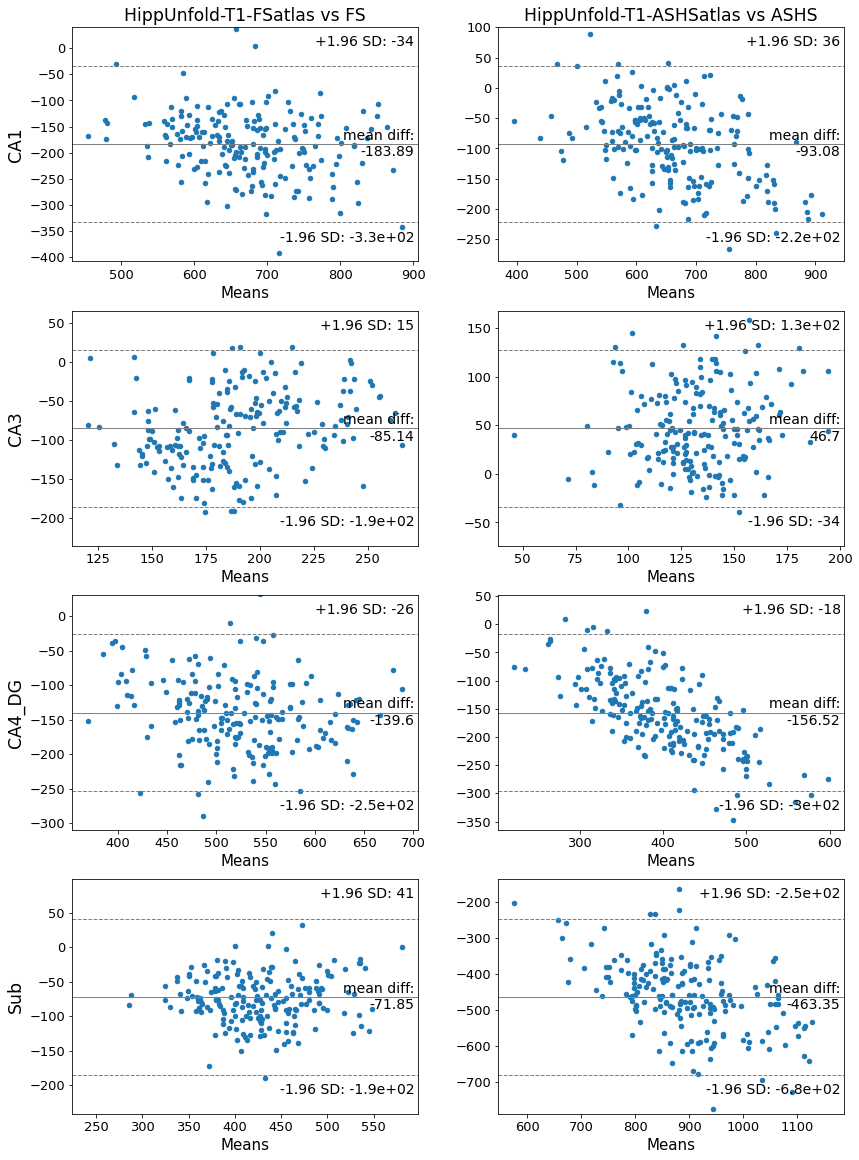

In [157]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

subfields = ['CA1','CA3','CA4_DG','Sub']

methods1 = ['HippUnfold-T1-FSatlas','HippUnfold-T1-ASHSatlas']
methods2 = ['FS','ASHS']
plot_bland_altman(df,methods1,methods2,subfields,figsize=(12,16))

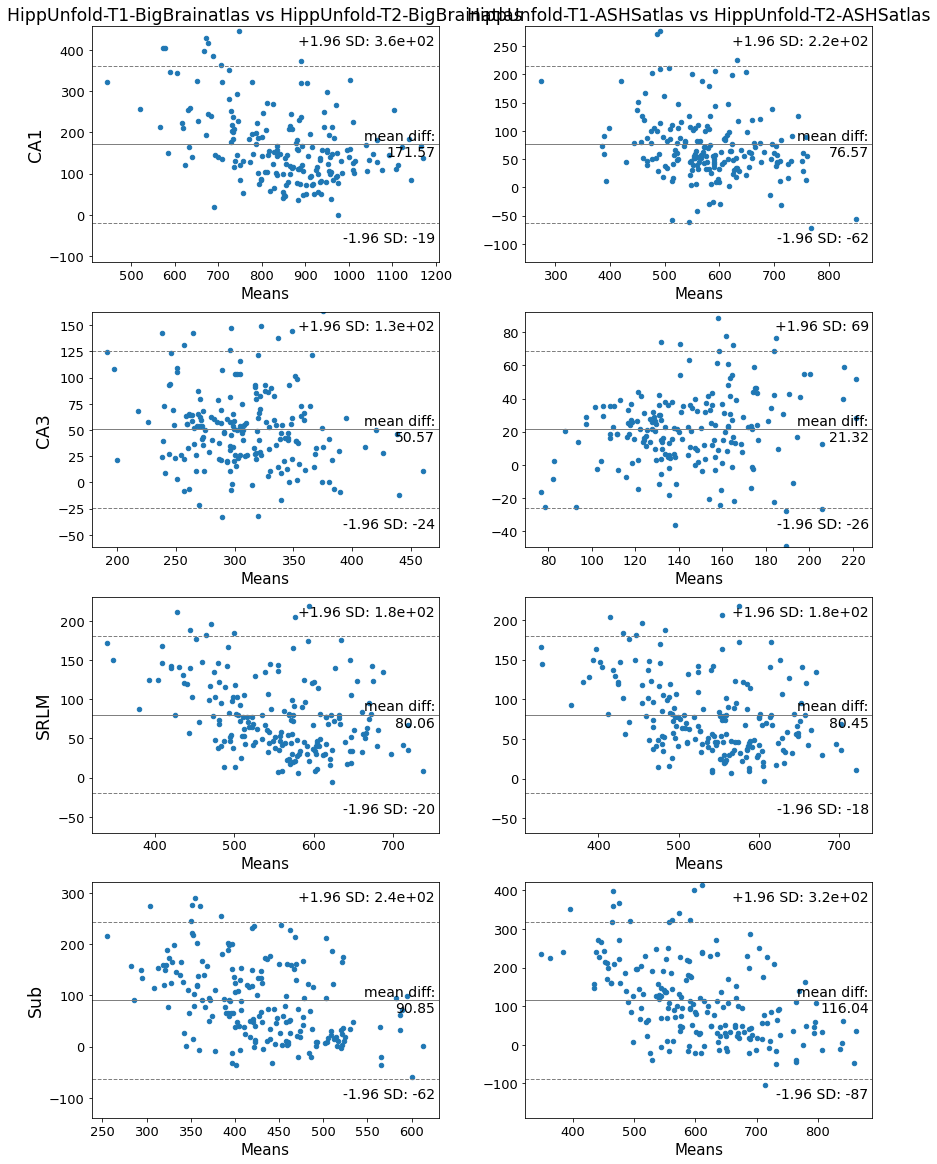

In [161]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

subfields = ['CA1','CA3','SRLM','Sub']

methods1 = ['HippUnfold-T1-BigBrainatlas','HippUnfold-T1-ASHSatlas']
methods2 = ['HippUnfold-T2-BigBrainatlas','HippUnfold-T2-ASHSatlas']
plot_bland_altman(df,methods1,methods2,subfields,figsize=(12,16))

## Vol vs Age plots

In [193]:
def plot_scatter(df,methods1,methods2,subfields,figsize=(30,15)):


    f, axs = plt.subplots(ncols=len(methods1),nrows=len(subfields), figsize=figsize,squeeze=False)


    for i,(method1,method2) in enumerate(zip(methods1,methods2)):
        for j,subfield in enumerate(subfields):

            sns.regplot(data=(df
                    .query(f'subfield == "{subfield}" and method == "{method1}"')
                             )
                            ,x='age',y='volume',ax=axs[j][i],label=method1)
            sns.regplot(data=(df
                    .query(f'subfield == "{subfield}" and method == "{method2}"')
                             )
                            ,x='age',y='volume',ax=axs[j][i],label=method2)        

            axs[j,i].legend()

    #add column and row labels:

    rows = subfields
    cols = [f'{method1} vs {method2}' for method1,method2 in zip(methods1,methods2) ]


    for ax, col in zip(axs[0], cols):
        ax.set_title(col,size='xx-large')

    for ax, row in zip(axs[:,0], rows):
        ax.set_ylabel(row, rotation=90, size='xx-large')

    if len(cols)>1:
        for j in range(1,len(cols)):
            for ax in axs[:,j]:
                ax.set_ylabel('')

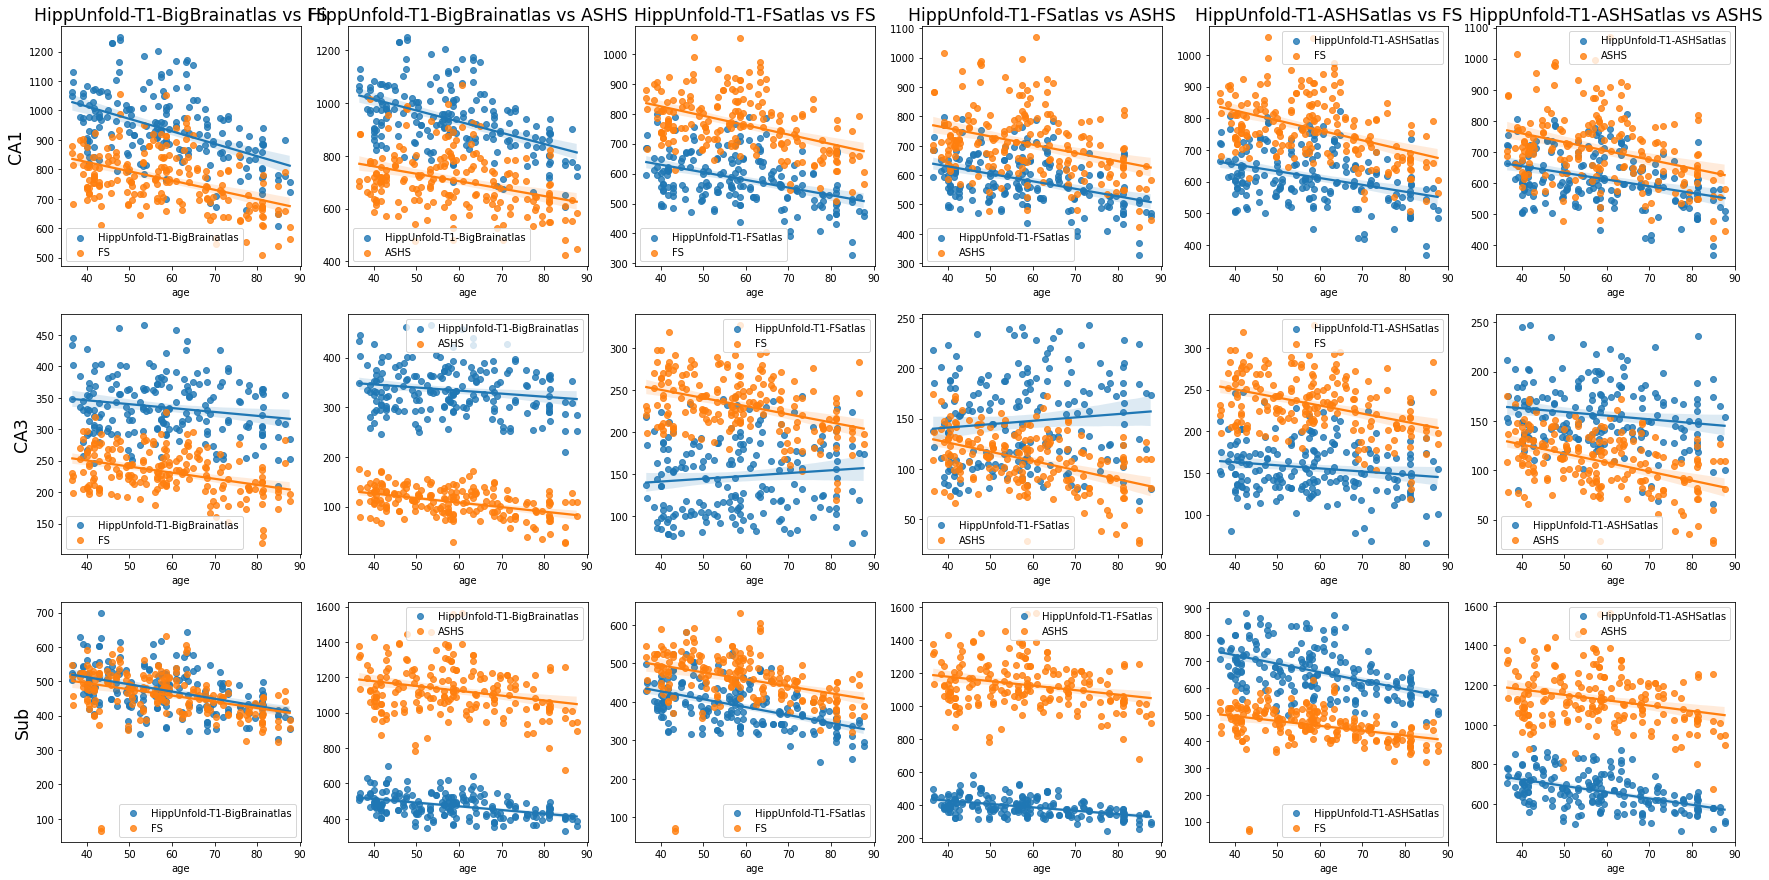

In [194]:
import seaborn as sns


methods1 = ['HippUnfold-T1-BigBrainatlas','HippUnfold-T1-BigBrainatlas','HippUnfold-T1-FSatlas','HippUnfold-T1-FSatlas','HippUnfold-T1-ASHSatlas','HippUnfold-T1-ASHSatlas']
methods2 = ['FS','ASHS','FS','ASHS','FS','ASHS']
subfields = ['CA1','CA3','Sub']

plot_scatter(df,methods1,methods2,subfields)

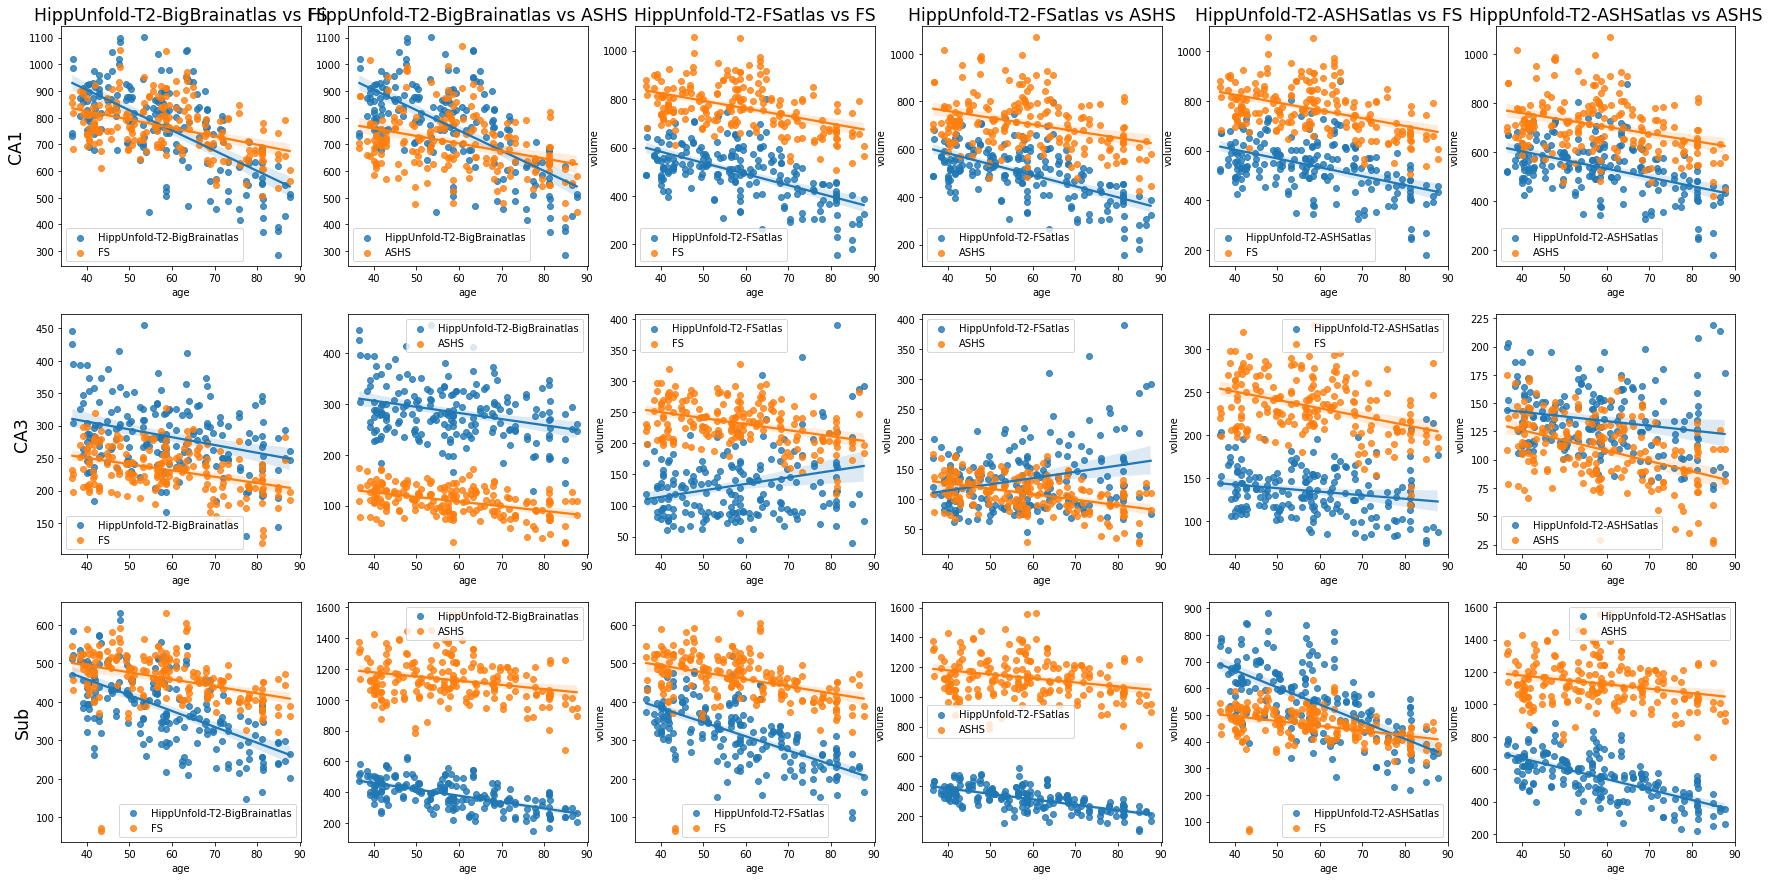

In [166]:
import seaborn as sns

#compare hippunfold run on T2 TSE (and various atlases) with FS and ASHS

methods1 = ['HippUnfold-T2-BigBrainatlas','HippUnfold-T2-BigBrainatlas','HippUnfold-T2-FSatlas','HippUnfold-T2-FSatlas','HippUnfold-T2-ASHSatlas','HippUnfold-T2-ASHSatlas']
methods2 = ['FS','ASHS','FS','ASHS','FS','ASHS']
subfields = ['CA1','CA3','Sub']


plot_scatter(df,methods1,methods2,subfields)

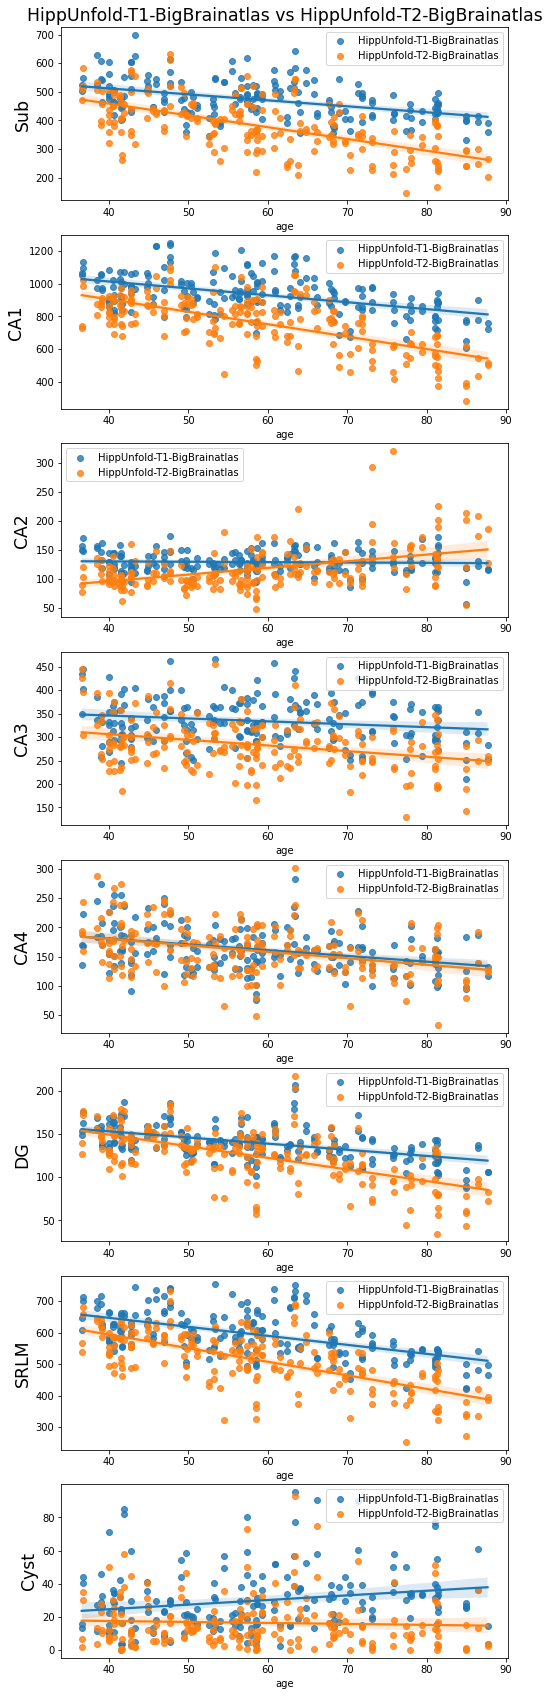

In [200]:

#compare hippunfold run on T2 TSE  with T1w for all subfield labels


methods1 = ['HippUnfold-T1-BigBrainatlas'] 
methods2 = ['HippUnfold-T2-BigBrainatlas']

subfields = all_subfields['hippunfold-t1-bigbrainatlas']


plot_scatter(df,methods1,methods2,subfields,figsize=(8,30))

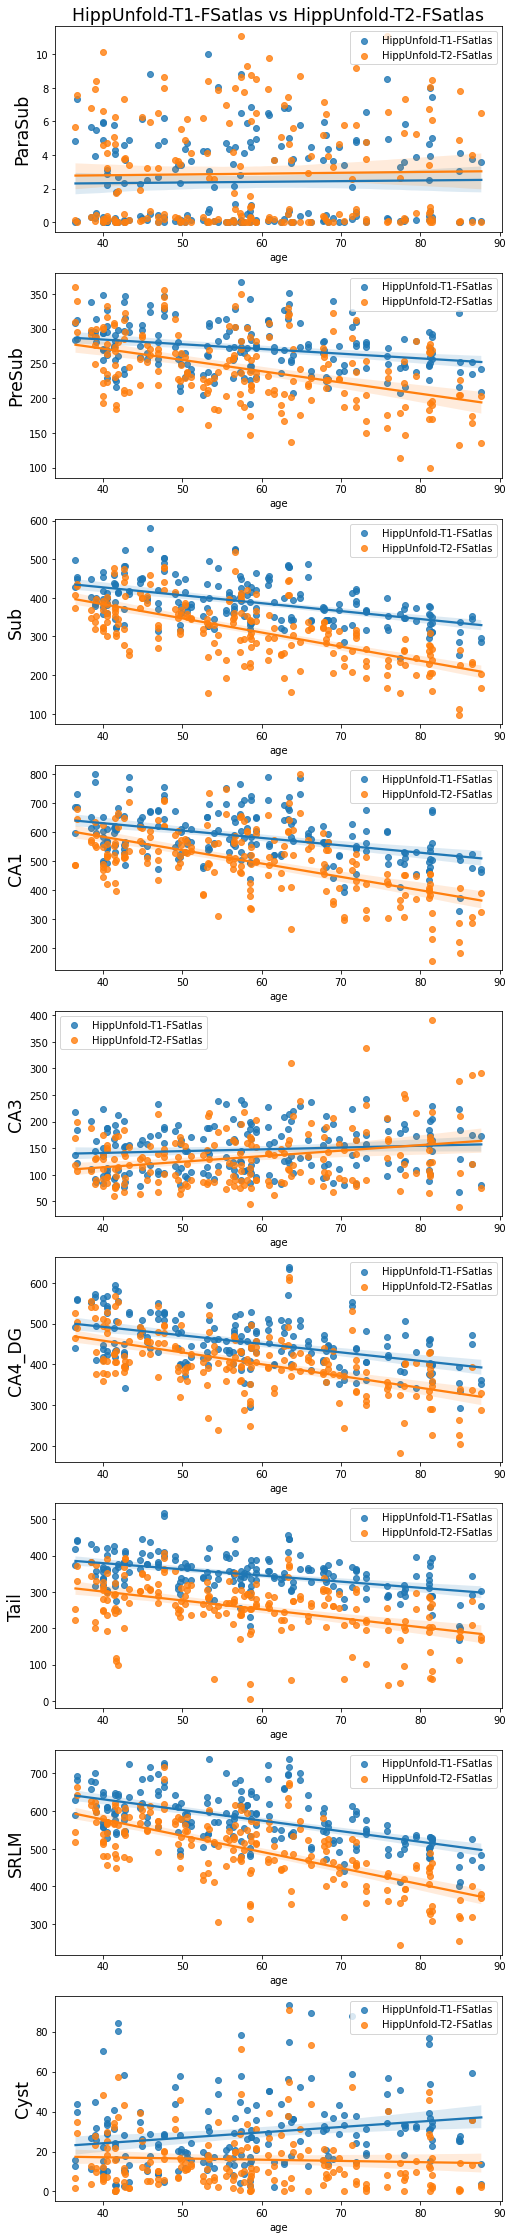

In [202]:
#compare hippunfold run on T2 TSE  with T1w for all subfield labels


methods1 = ['HippUnfold-T1-FSatlas'] 
methods2 = ['HippUnfold-T2-FSatlas']

subfields = all_subfields['hippunfold-t1-freesurferatlas']


plot_scatter(df,methods1,methods2,subfields,figsize=(8,40))

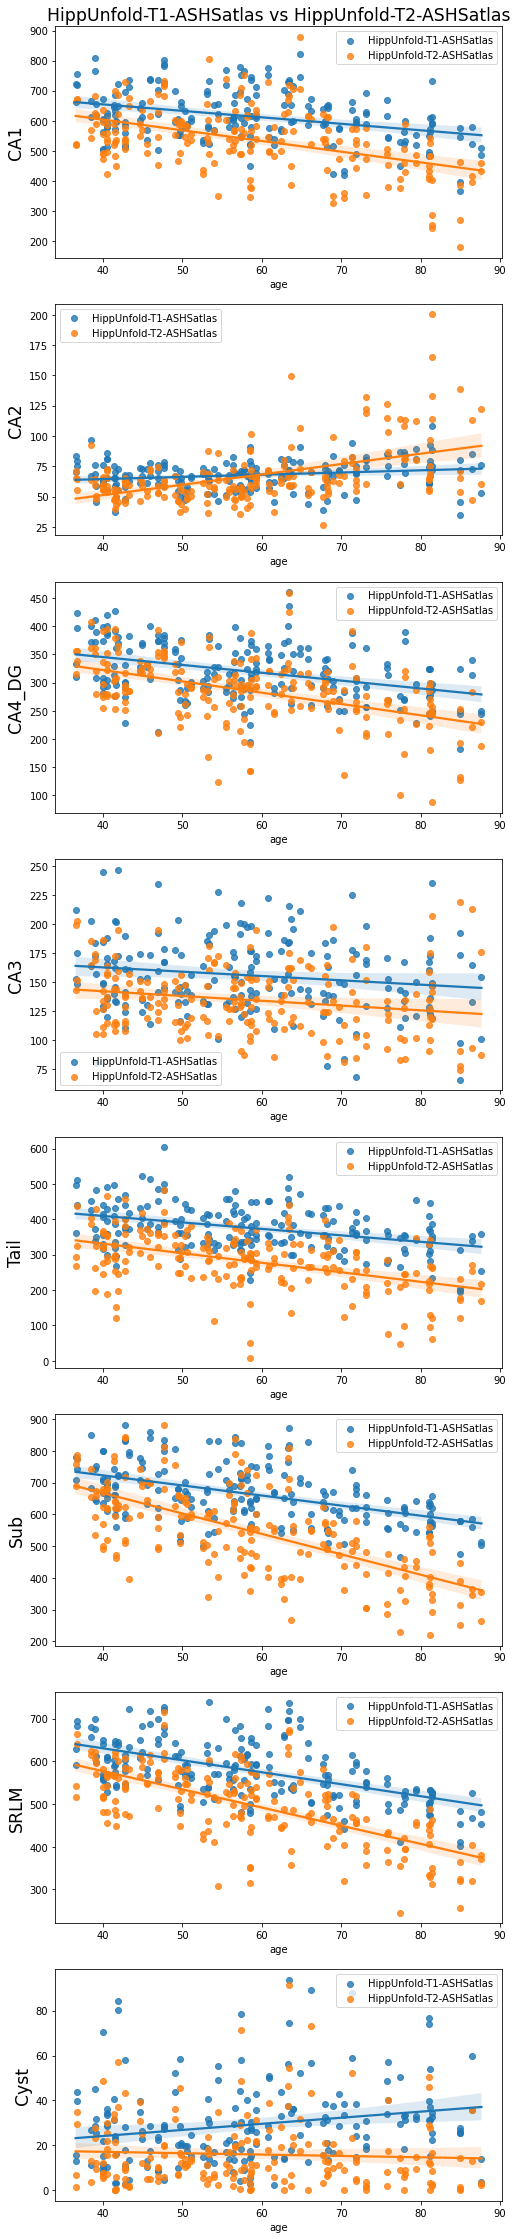

In [203]:
#compare hippunfold run on T2 TSE  with T1w for all subfield labels


methods1 = ['HippUnfold-T1-ASHSatlas'] 
methods2 = ['HippUnfold-T2-ASHSatlas']

subfields = all_subfields['hippunfold-t1-magdeburgatlas']


plot_scatter(df,methods1,methods2,subfields,figsize=(8,40))

In [204]:
sns.lmplot(data=df,x='age',y='volume',col='method',row='subfield')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fb885e27550> (for post_execute):



KeyboardInterrupt

